<a href="https://colab.research.google.com/github/SveBB/Notebooks/blob/main/PsyDL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Использование глубокого обучения для прогнозирования психологических характеристик**



#Подкючение библиотек

In [ ]:
import keras as k
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from datetime import date
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.preprocessing import MultiLabelBinarizer

#Загрузка данных

In [ ]:
profiles = pd.read_csv('/content/drive/MyDrive/Data/Profiles.csv')
results = pd.read_csv('/content/drive/MyDrive/Data/Results.csv')
fields = pd.read_csv('/content/drive/MyDrive/Data/fields1.csv', sep=';')

#Подготовка данных

In [ ]:
#Слияние данных + удаление данных по id
data = profiles.merge(fields, on = 'id')
results = results.rename({"id_vk": "id"}, axis='columns')
data = data.merge(results, on = 'id', how = 'right').drop_duplicates(subset = ['id']).set_index('id')
#Удаление заблокированных и забаненных пользователей
data = data.loc[data.deactivated.isnull()].drop(labels='deactivated', axis = 1)
#Удаление пользователей с закрытым профилем
data = data[~data['is_closed'].isin([True])].drop(labels='is_closed', axis = 1)
#Удаление лишних признаков
status_audio = ['status_audio_artist','status_audio_id','status_audio_owner_id','status_audio_title','status_audio_duration',
                'status_audio_url','status_audio_date','status_audio_is_hq','status_audio_main_artists','status_audio_short_videos_allowed',
                'status_audio_stories_allowed','status_audio_is_explicit','status_audio_subtitle','status_audio_lyrics_id',
                'status_audio_genre_id','status_audio_stories_cover_allowed']
for_delete = ['id_moodle','дата','Unnamed: 6', 'дата.1','дата.2','friends_online_count',
              'can_access_closed','domain','bdate','followers_count_x','false']
data = data.drop(labels = status_audio+for_delete, axis = 1)

#Университет, школа, карьера
data['university'] = 0
data['school'] = 0
data['career'] = 0

university_list = ['universities_chair', 'universities_chair_name','universities_city','universities_country',
                   'universities_education_form','universities_education_status','universities_faculty',
                   'universities_faculty_name','universities_graduation','universities_id','universities_name']
data[university_list] = data[university_list].fillna('0')

school_list = ['schools_city','schools_country','schools_id','schools_name','schools_type','schools_type_str',
               'schools_year_from','schools_year_graduated','schools_year_to','schools_speciality','schools_class']
data[school_list] = data[school_list].fillna('0')

career_list = ['career_city_id','career_country_id','career_group_id','career_company',
               'career_from','career_position','career_until']
data[career_list] = data[career_list].fillna('0')

for i in university_list:
    data.loc[data[i] != '0', 'university'] = 1
data = data.drop(labels= university_list, axis = 1)

for i in school_list:
    data.loc[data[i] != '0', 'school'] = 1
data = data.drop(labels= school_list, axis = 1)

for i in career_list:
    data.loc[data[i] != '0', 'career'] = 1         
data = data.drop(labels= career_list, axis = 1)

#Заполненность профиля
fullness_profile_list = ['skype','mobile_phone','maiden_name','instagram','site','quotes','relation','personal_people_main',
                         'home_town','personal_alcohol','personal_langs','personal_political','personal_religion',
                         'personal_smoking','relatives_type','relatives_id','nickname','activities',
                         'personal_inspired_by','personal_life_main','books','tv','about','movies','music','home_phone',
                         'relation_partner_first_name','relation_partner_id','relation_partner_last_name','personal_religion_id',
                         'relatives_name','games','twitter','facebook','facebook_name']
data['profile_fulness'] = 0
data['profile_fulness'] = data['profile_fulness'].astype('float64')
data[fullness_profile_list] = data[fullness_profile_list].fillna('0')
for i in fullness_profile_list:
    data.loc[data[i] != '0', 'profile_fulness'] += 1
data['profile_fulness']= data['profile_fulness']/len(fullness_profile_list)*100
data = data.drop(labels= fullness_profile_list, axis = 1)
#Пол
data['sex'] = data['sex'].apply(lambda x: 0 if x == 1 else 1)
#Обработка возраста
data = data.rename({"bdate_1c": "age"}, axis='columns')
data.age = data.age.fillna('0')
def age_handle(age):
    if age != '0':
        born = datetime.strptime(age[:10], '%Y-%m-%d').date()
        today = date.today()
        result = today.year - born.year - ((today.month, today.day) < (born.month, born.day))
        return result
    else:
        return 0

data['age'] = data['age'].apply(lambda x: age_handle(x))

#Факультеты
data['подразделение 1'] = data['подразделение 1'].fillna('0')

technical = ['ММФ','ФТФ','ФИТ','ИПМиКН','РФФ','ИПМКН','HITS','ФтФ']
humanitarian = ['ФП','ИЭМ','САЕ ИЧЦЭ','НЮИ', 'ФсФ', 'ЮИ','ИИК','ФИПН''ФлФ', 'ФИЯ','ФЖ','ФилФ','ФФ','ФлФ',
                'САЕ ЦИТСНУ','ФСФ','ФЛФ','Управление информационной политики','кафедра истории философии','ФИПН']
natural = ['БИ','ХФ','САЕ ИУМТ','ФФК','ГГФ','САЕ ИБМ']

for i in data.index:
    if data['подразделение 1'][i] != 0:
        if data['подразделение 1'][i] in technical: 
            data['подразделение 1'][i] = '1'
        if data['подразделение 1'][i] in humanitarian: 
            data['подразделение 1'][i] = '2'
        if data['подразделение 1'][i] in natural: 
            data['подразделение 1'][i] = '3'
        if data['подразделение 1'][i] == 'ИВО':
            data['подразделение 1'][i] = '4'
        if data['подразделение 1'][i] == 'не ТГУ':
            data['подразделение 1'][i] = '0'
data['подразделение 1'] = pd.to_numeric(data['подразделение 1'])
data = data.rename({"подразделение 1": "subdivision"}, axis='columns')

#Наличие статуса
data['status'] = data['status'].fillna('0')
data['status'] = data['status'].apply(lambda x: 1 if x != '0' else 0)
data['status'] = pd.to_numeric(data['status'])

#Города и страны, вопрос
data = data.drop(labels = ['city_id',
 'city_title',
 'country_id',
 'country_title'], axis = 1)
#Заполнение пропусков
data.albums_count = data.albums_count.fillna(data.albums_count.mean())
data.photos_count = data.photos_count.fillna(data.photos_count.mean())
data.friends_count = data.friends_count.fillna(data.friends_count.mean())
data.groups_count = data.groups_count.fillna(data.groups_count.mean())
data.followers_count_y = data.followers_count_y.fillna(data.followers_count_y.mean())
data.subscriptions_count = data.subscriptions_count.fillna(data.subscriptions_count.mean())
#One-hot-encoding
data = pd.get_dummies(data, columns=['subdivision']).drop(labels = 'subdivision_0', axis =1)

l1 = ['Экстраверсия',
 'Сознательность',
 'Доброжелательность',
 'Эмоциональная устойчивость',
 'Открытость опыту','false.1',
 'false.2']

l2 = ['Подавленность',
 'Тревожность',
 'Стресс',
 'false.1','false.2']

data['false.1'] = data['false.1'].fillna('1')
data['false.2'] = data['false.2'].fillna('1')

data1 = data.copy()
data1 = data1[~data1['false.1'].isin(['1'])].drop(labels=l1, axis = 1)
data2 = data.copy()
data2 = data2[~data2['false.2'].isin(['1'])].drop(labels=l2, axis = 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to b

#Обработка первого теста



In [ ]:
quantitative_names = ['albums_count', 'photos_count', 'friends_count',
                      'groups_count', 'followers_count_y', 
                      'subscriptions_count', 'age', 'profile_fulness']

categorical_names = ['sex', 'status', 'university', 'school',
                     'career', 'subdivision_1', 'subdivision_2',
                      'subdivision_3', 'subdivision_4']

output_names = ['Подавленность', 'Тревожность', 'Стресс']

##Нормализация входных количественных признаков

In [ ]:
max_data = data1[quantitative_names].max()
max_data

albums_count              74.000000
photos_count            3035.000000
friends_count           5000.000000
groups_count            2314.000000
followers_count_y      18755.000000
subscriptions_count     2090.000000
age                       57.000000
profile_fulness           71.428571
dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


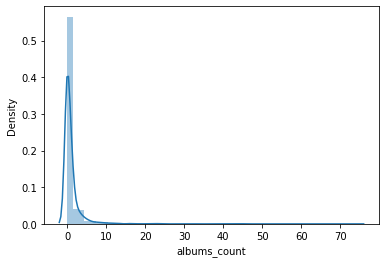

In [ ]:
sns_plot = sns.distplot(data1['albums_count'] )
fig = sns_plot.get_figure()

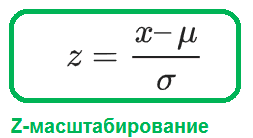

In [ ]:
def z_score(df):
    # copy the dataframe
    df_std = df.copy()
    # apply the z-score method
    for column in df_std.columns:
        df_std[column] = (df_std[column] - df_std[column].mean()) / df_std[column].std()
        
    return df_std
  
data1[quantitative_names] = z_score(data1[quantitative_names])
data1.describe()

,sex,status,albums_count,photos_count,friends_count,groups_count,followers_count_y,subscriptions_count,Подавленность,Тревожность,Стресс,age,university,school,career,profile_fulness,subdivision_1,subdivision_2,subdivision_3,subdivision_4
count,2563.000000,2563.000000,2.563000e+03,2.563000e+03,2.563000e+03,2.563000e+03,2.563000e+03,2.563000e+03,2563.000000,2563.000000,2563.000000,2.563000e+03,2563.000000,2563.000000,2563.000000,2.563000e+03,2563.000000,2563.000000,2563.000000,2563.000000
mean,0.347249,0.408896,-2.808305e-15,1.140329e-16,2.588643e-16,-1.477121e-17,-2.017071e-16,-1.957077e-16,7.422162,5.310964,9.159579,8.325590e-17,0.428404,0.280921,0.066719,5.290605e-15,0.216543,0.586812,0.185720,0.000780
std,0.476189,0.491726,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,5.489584,4.735764,5.624252,1.000000e+00,0.494944,0.449537,0.249583,1.000000e+00,0.411969,0.492502,0.388956,0.027929
min,0.000000,0.000000,-3.287062e-01,-2.384685e-01,-6.428604e-01,-7.011192e-01,-3.847295e-01,-6.941641e-01,0.000000,0.000000,0.000000,-1.971353e+00,0.000000,0.000000,0.000000,-8.439019e-01,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,-3.287062e-01,-2.203309e-01,-4.018972e-01,-5.251881e-01,-2.898347e-01,-5.222308e-01,3.000000,1.000000,5.000000,4.887001e-02,0.000000,0.000000,0.000000,-5.811883e-01,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,-3.287062e-01,-1.749869e-01,-2.016602e-01,-2.801412e-01,-1.380031e-01,-2.746467e-01,6.000000,4.000000,9.000000,2.733392e-01,0.000000,0.000000,0.000000,-3.184748e-01,0.000000,1.000000,0.000000,0.000000
75%,1.000000,1.000000,-1.719833e-02,-7.523022e-02,9.360455e-02,1.408367e-01,5.705831e-02,1.242388e-01,12.000000,8.000000,13.000000,4.978085e-01,1.000000,1.000000,0.000000,4.696658e-01,0.000000,1.000000,0.000000,0.000000
max,1.000000,1.000000,2.272288e+01,2.728532e+01,1.632638e+01,1.383833e+01,3.916529e+01,1.367947e+01,21.000000,21.000000,21.000000,4.426020e+00,1.000000,1.000000,1.000000,5.723936e+00,1.000000,1.000000,1.000000,1.000000


##Категоризация выходных данных

In [ ]:
data1['Подавленность'] = data1['Подавленность'].apply(lambda x: 1 if x > 7 else 0)
data1['Тревожность'] = data1['Тревожность'].apply(lambda x: 1 if x > 6 else 0)
data1['Стресс'] = data1['Стресс'].apply(lambda x: 1 if x > 10 else 0)

##Проверка и преобразование в np.array

In [ ]:
data1.describe()

,sex,status,albums_count,photos_count,friends_count,groups_count,followers_count_y,subscriptions_count,Подавленность,Тревожность,Стресс,age,university,school,career,profile_fulness,subdivision_1,subdivision_2,subdivision_3,subdivision_4
count,2563.000000,2563.000000,2.563000e+03,2.563000e+03,2.563000e+03,2.563000e+03,2.563000e+03,2.563000e+03,2563.000000,2563.000000,2563.000000,2.563000e+03,2563.000000,2563.000000,2563.000000,2.563000e+03,2563.000000,2563.000000,2563.000000,2563.000000
mean,0.347249,0.408896,-2.808305e-15,1.140329e-16,2.588643e-16,-1.477121e-17,-2.017071e-16,-1.957077e-16,0.437378,0.335544,0.398361,8.325590e-17,0.428404,0.280921,0.066719,5.290605e-15,0.216543,0.586812,0.185720,0.000780
std,0.476189,0.491726,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.496160,0.472273,0.489656,1.000000e+00,0.494944,0.449537,0.249583,1.000000e+00,0.411969,0.492502,0.388956,0.027929
min,0.000000,0.000000,-3.287062e-01,-2.384685e-01,-6.428604e-01,-7.011192e-01,-3.847295e-01,-6.941641e-01,0.000000,0.000000,0.000000,-1.971353e+00,0.000000,0.000000,0.000000,-8.439019e-01,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,-3.287062e-01,-2.203309e-01,-4.018972e-01,-5.251881e-01,-2.898347e-01,-5.222308e-01,0.000000,0.000000,0.000000,4.887001e-02,0.000000,0.000000,0.000000,-5.811883e-01,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,-3.287062e-01,-1.749869e-01,-2.016602e-01,-2.801412e-01,-1.380031e-01,-2.746467e-01,0.000000,0.000000,0.000000,2.733392e-01,0.000000,0.000000,0.000000,-3.184748e-01,0.000000,1.000000,0.000000,0.000000
75%,1.000000,1.000000,-1.719833e-02,-7.523022e-02,9.360455e-02,1.408367e-01,5.705831e-02,1.242388e-01,1.000000,1.000000,1.000000,4.978085e-01,1.000000,1.000000,0.000000,4.696658e-01,0.000000,1.000000,0.000000,0.000000
max,1.000000,1.000000,2.272288e+01,2.728532e+01,1.632638e+01,1.383833e+01,3.916529e+01,1.367947e+01,1.000000,1.000000,1.000000,4.426020e+00,1.000000,1.000000,1.000000,5.723936e+00,1.000000,1.000000,1.000000,1.000000


In [ ]:
data1

,sex,status,albums_count,photos_count,friends_count,groups_count,followers_count_y,subscriptions_count,Подавленность,Тревожность,Стресс,age,university,school,career,profile_fulness,subdivision_1,subdivision_2,subdivision_3,subdivision_4
id,,,,,,,,,,,,,,,,,,,,
43444,0,1,0.294310,2.264518,0.395657,-0.204742,0.802509,-0.130223,0,0,0,1.283451,0,0,0,-0.318475,0,1,0,0
410375,0,0,-0.328706,-0.229400,-0.052331,-0.701119,-0.304596,-0.694164,0,0,0,0.048870,0,0,0,-0.581188,0,1,0,0
906554,1,1,3.720896,6.980291,2.174033,-0.500055,0.081309,-0.467212,0,0,0,-1.971353,0,0,0,-0.318475,0,1,0,0
926219,0,1,-0.328706,0.931406,0.096998,-0.468639,-0.013586,-0.453457,0,0,0,2.293562,1,1,0,0.206952,0,1,0,0
1180608,1,0,-0.328706,1.094644,3.005526,0.040305,0.051786,0.082975,0,0,0,1.620155,0,0,0,-0.843902,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
614291922,0,0,-0.328706,-0.229400,-0.639467,-0.694836,-0.384729,-0.694164,0,0,0,0.497808,0,0,0,-0.581188,0,1,0,0
614336441,1,0,-0.328706,-0.238468,-0.636073,-0.638287,-0.384729,-0.632268,1,1,1,0.048870,1,0,0,0.995093,0,0,1,0
616747127,0,0,-0.328706,-0.229400,-0.632679,-0.701119,-0.372077,-0.694164,0,1,0,1.058982,1,0,0,-0.318475,0,0,1,0


In [ ]:
encoded_inputs = np.array(data1[quantitative_names + categorical_names])
encoded_outputs=  np.array(data1['Подавленность'])

In [ ]:
encoded_inputs

array([[ 0.29430953,  2.26451834,  0.39565701, ...,  1.        ,
         0.        ,  0.        ],
       [-0.32870619, -0.2293997 , -0.05233091, ...,  1.        ,
         0.        ,  0.        ],
       [ 3.72089597,  6.98029063,  2.17403327, ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [-0.32870619, -0.2293997 , -0.63267889, ...,  0.        ,
         1.        ,  0.        ],
       [-0.32870619, -0.2293997 , -0.54104499, ...,  1.        ,
         0.        ,  0.        ],
       [-0.32870619, -0.2293997 , -0.63607273, ...,  1.        ,
         0.        ,  0.        ]])

In [ ]:
encoded_inputs.shape

(2563, 17)

##Разбиение выборки

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(encoded_inputs, encoded_outputs, test_size=0.3, random_state=42)

##Создание и обучение модели

In [ ]:
model = k.Sequential()
model.add(k.layers.Dense(units = 17, input_dim = 17, activation = "relu"))

model.add(k.layers.Dense(units = 1, activation = "sigmoid"))
model.compile(loss = 'binary_crossentropy', optimizer = "sgd", metrics = ["accuracy"])

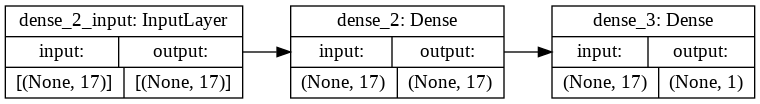

In [ ]:
k.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [ ]:
fit_results = model.fit(x = X_train, y = y_train, epochs = 250, validation_split = 0.3)

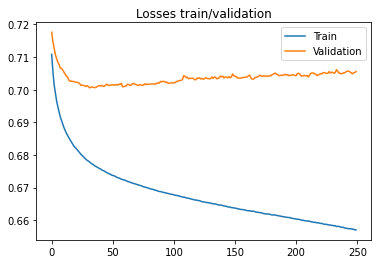

In [ ]:
plt.title("Losses train/validation")
plt.plot(fit_results.history["loss"], label = "Train")
plt.plot(fit_results.history["val_loss"], label = "Validation")
plt.legend()
plt.show()

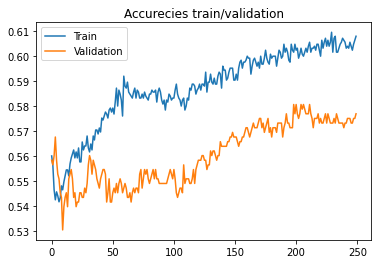

In [ ]:
plt.title("Accurecies train/validation")
plt.plot(fit_results.history["accuracy"], label = "Train")
plt.plot(fit_results.history["val_accuracy"], label = "Validation")
plt.legend()
plt.show()

In [ ]:
prediction = model.predict(X_test)
print(prediction.mean(), prediction.max())

0.44251856 0.91617584


In [ ]:
squarer = lambda t: 1 if t > 0.45 else 0
vfunc = np.vectorize(squarer)
res = vfunc(prediction)

In [ ]:
from sklearn.metrics import accuracy_score
pr = precision_score(y_test, res)
re = recall_score(y_test, res) 
f1 = f1_score(y_test, res)
ac = accuracy_score(y_test, res)
print('Precision', pr)
print('Recall', re)
print('f1', f1)
print('accuracy', ac)

Precision 0.4971751412429379
Recall 0.5161290322580645
f1 0.5064748201438849
accuracy 0.5539661898569571


##Создание и обучение модели с данными о подписках

In [ ]:
publics = pd.read_csv("/content/drive/MyDrive/Data/groups.csv")
publics = publics.drop(columns = ['groups'])
publics = publics.dropna(subset = ['publics'])
pub_cop = publics.copy()
pub_cop.publics = pub_cop.publics.apply(lambda x:x.split(',')[:50])

In [ ]:
mlb = MultiLabelBinarizer()
new_pub = pd.DataFrame(mlb.fit_transform(pub_cop.publics), columns = mlb.classes_, index = pub_cop.user_id)

In [ ]:
new_data = data1.join(new_pub, on = 'id', how = 'inner')
new_data

,sex,status,albums_count,photos_count,friends_count,groups_count,followers_count_y,subscriptions_count,Подавленность,Тревожность,Стресс,age,university,school,career,profile_fulness,subdivision_1,subdivision_2,subdivision_3,subdivision_4,100021690,1000464,100057462,100069703,100083164,100118438,10012761,100157872,100161516,100174482,100191889,100195504,100207739,100214775,100225617,100234208,100235,100235136,100239221,10024631,...,99569891,99579822,99600394,99610165,99613308,99621595,99626804,99628911,99635730,99641219,99659133,99683830,99707783,99707911,99715615,99734147,99735936,99750523,99776591,99786151,99802463,99813121,99821128,99825912,99827473,99846677,998490,99853623,99861136,99869018,99872432,99898680,99909598,99942849,99944683,99951828,99954096,99969239,99973027,99985606
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
43444,0,1,0.294310,2.264518,0.395657,-0.204742,0.802509,-0.130223,0,0,0,1.283451,0,0,0,-0.318475,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
906554,1,1,3.720896,6.980291,2.174033,-0.500055,0.081309,-0.467212,0,0,0,-1.971353,0,0,0,-0.318475,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
926219,0,1,-0.328706,0.931406,0.096998,-0.468639,-0.013586,-0.453457,0,0,0,2.293562,1,1,0,0.206952,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1180608,1,0,-0.328706,1.094644,3.005526,0.040305,0.051786,0.082975,0,0,0,1.620155,0,0,0,-0.843902,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1493119,1,1,0.294310,0.205902,3.687689,0.147120,0.298513,0.248031,1,0,1,-1.971353,0,0,0,-0.581188,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
613005362,1,0,-0.328706,-0.238468,-0.612316,-0.675986,-0.382621,-0.680409,0,0,0,0.048870,0,0,0,-0.581188,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
613857360,0,0,-0.328706,-0.229400,-0.530863,-0.682269,-0.359424,-0.673532,1,1,1,0.834512,1,0,0,-0.318475,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
614336441,1,0,-0.328706,-0.238468,-0.636073,-0.638287,-0.384729,-0.632268,1,1,1,0.048870,1,0,0,0.995093,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
encoded_pub_inputs = np.array(new_data.drop(labels = output_names, axis = 1))
encoded_pub_outputs=  np.array(new_data['Подавленность'])

In [ ]:
encoded_pub_inputs.shape

(2344, 26442)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(encoded_pub_inputs, encoded_pub_outputs, test_size=0.3, random_state=42)

In [ ]:
X_train.shape

(1640, 26442)

In [ ]:
callback = k.callbacks.EarlyStopping(monitor='loss', patience=1)

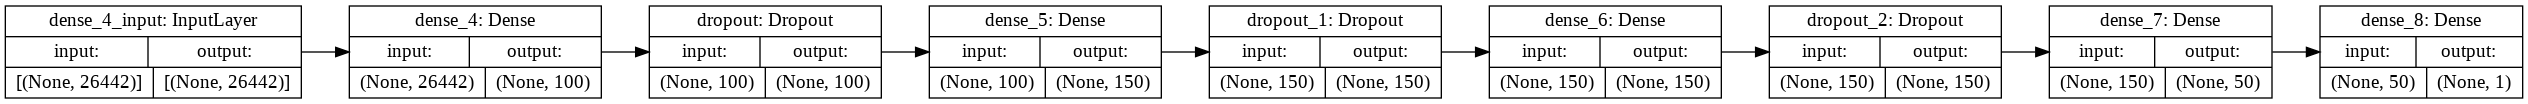

In [ ]:
model = k.Sequential()
model.add(k.layers.Dense(units = 100, input_dim = 26442, activation = "relu"))
model.add(k.layers.Dropout(0.5))
model.add(k.layers.Dense(units = 150, activation = "relu"))
model.add(k.layers.Dropout(0.5))
model.add(k.layers.Dense(units = 150, activation = "relu"))
model.add(k.layers.Dropout(0.5))
model.add(k.layers.Dense(units = 50, activation = "relu"))
model.add(k.layers.Dense(units = 1, activation = "sigmoid"))
model.compile(loss = 'binary_crossentropy', optimizer = "adam", metrics = ["accuracy"])
k.utils.plot_model(model, show_shapes=True, rankdir="LR")


In [ ]:
fit_results = model.fit(x = X_train, y = y_train, epochs = 100, validation_split = 0.2, batch_size= 512, callbacks=[callback])

Epoch 1/100
3/3 [==============================] - 1s 266ms/step - loss: 0.6923 - accuracy: 0.5325 - val_loss: 0.6883 - val_accuracy: 0.5793
Epoch 2/100
3/3 [==============================] - 0s 172ms/step - loss: 0.6846 - accuracy: 0.5669 - val_loss: 0.6840 - val_accuracy: 0.5793
Epoch 3/100
3/3 [==============================] - 1s 176ms/step - loss: 0.6740 - accuracy: 0.5643 - val_loss: 0.6796 - val_accuracy: 0.5793
Epoch 4/100
3/3 [==============================] - 0s 163ms/step - loss: 0.6592 - accuracy: 0.5710 - val_loss: 0.6761 - val_accuracy: 0.5793
Epoch 5/100
3/3 [==============================] - 0s 173ms/step - loss: 0.6384 - accuracy: 0.5724 - val_loss: 0.6740 - val_accuracy: 0.5793
Epoch 6/100
3/3 [==============================] - 0s 166ms/step - loss: 0.6137 - accuracy: 0.5593 - val_loss: 0.6726 - val_accuracy: 0.5793
Epoch 7/100
3/3 [==============================] - 0s 172ms/step - loss: 0.5673 - accuracy: 0.5711 - val_loss: 0.6726 - val_accuracy: 0.5854
Epoch 8/100
3

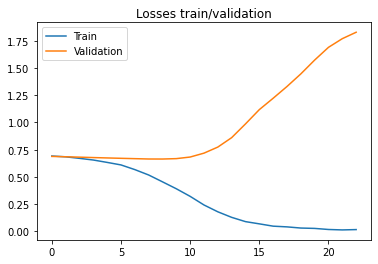

In [ ]:
plt.title("Losses train/validation")
plt.plot(fit_results.history["loss"], label = "Train")
plt.plot(fit_results.history["val_loss"], label = "Validation")
plt.legend()
plt.show()

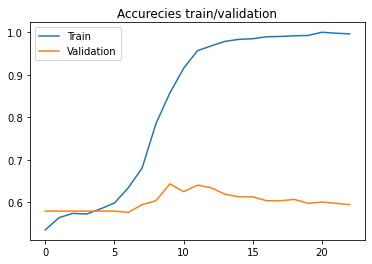

In [ ]:
plt.title("Accurecies train/validation")
plt.plot(fit_results.history["accuracy"], label = "Train")
plt.plot(fit_results.history["val_accuracy"], label = "Validation")
plt.legend()
plt.show()

In [ ]:
prediction = model.predict(X_test)
print(prediction.mean(), prediction.max())

0.35659644 0.9999697


In [ ]:
squarer = lambda t: 1 if t > 0.45 else 0
vfunc = np.vectorize(squarer)
res = vfunc(prediction)

In [ ]:
from sklearn.metrics import accuracy_score
pr = precision_score(y_test, res)
re = recall_score(y_test, res) 
f1 = f1_score(y_test, res)
ac = accuracy_score(y_test, res)
print('Precision', pr)
print('Recall', re)
print('f1', f1)
print('accuracy', ac)

Precision 0.5
Recall 0.4088050314465409
f1 0.44982698961937717
accuracy 0.5482954545454546


In [ ]:
model = k.Sequential()
model.add(k.layers.Dense(units = 2344, activation = "softmax"))
model.add(k.layers.Dropout(0.5))
model.add(k.layers.Dense(units = 1117, activation = "softmax"))
model.add(k.layers.Dense(units = 558, activation = "softmax"))
model.add(k.layers.Dense(units = 279, activation = "softmax"))
model.add(k.layers.Dropout(0.5))
model.add(k.layers.Dense(units = 1, activation = "sigmoid"))
model.compile(loss = k.losses.BinaryCrossentropy(from_logits=True), optimizer = "adam", metrics = ["accuracy"])

In [ ]:
fit_results = model.fit(x = X_train, y = y_train, epochs = 100, validation_split = 0.2, batch_size= 256)